In [36]:
import libs
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from netCDF4 import Dataset
import time
import re

In [37]:
file_path_s1 = r"G:\0_postgraduate\DMSP\data\2011\15s1\dms_20110101_15s1.001.nc"
file_path_ut = r"G:\0_postgraduate\DMSP\data\2011\ut\dms_ut_20110101_15.002.nc"
s1 = libs.File(file_path_s1)
ut = libs.File(file_path_ut)
data_s1 = s1.original_data
data_ut = ut.original_data

In [38]:
def get_va(data_s1, data_ut):
    timestamps = data_ut['timestamps'].to_numpy()
    start_time = timestamps[0]
    end_time = timestamps[-1]
    ni = data_ut['ni'].to_numpy()
    po = data_ut['po+'].to_numpy()
    phe = data_ut['phe+'].to_numpy()
    ph = data_ut['ph+'].to_numpy()
    high_res_timestamps = data_s1['timestamps'].to_numpy()
    clipped_filter = (high_res_timestamps >= start_time) & (high_res_timestamps <= end_time)
    high_res_timestamps_clipped = high_res_timestamps[clipped_filter]
    
    # bd
    bd = data_s1['bd']
    bd_clipped = bd[clipped_filter]
    
    interp_function_ni = interp1d(timestamps, ni, kind='linear')
    high_res_ni = interp_function_ni(high_res_timestamps_clipped)
    interp_function_po = interp1d(timestamps, po, kind='linear')
    high_res_po = interp_function_po(high_res_timestamps_clipped)
    interp_function_phe = interp1d(timestamps, phe, kind='linear')
    high_res_phe = interp_function_phe(high_res_timestamps_clipped)
    interp_function_ph = interp1d(timestamps, ph, kind='linear')
    high_res_ph = interp_function_ph(high_res_timestamps_clipped)
    
    (mu0,r_mo,r_mh,r_mhe,NA) = (1.25663706212e-6,15.999,1.008,4.0026,6.02214076e23)  # r_mo 相对原子质量
    mo = r_mo / (1000 * NA)  # kg 国际标准单位
    mhe = r_mhe / (1000 * NA)  # kg 国际标准单位
    mh = r_mh / (1000 * NA)  # kg 国际标准单位
    no = high_res_ni*high_res_po
    nhe = high_res_ni*high_res_phe
    nh = high_res_ni*high_res_ph
    rho = no*mo + nhe*mhe + nh*mh
    va = bd_clipped / np.sqrt(mu0*rho)  # 索引问题：此处rho为ndarray没有index列，所以va的index由bd_clipped决定，而bd_clipped的index列是连续的
    return va,clipped_filter

Text(0.5, 1.0, 'vert_ion_v')

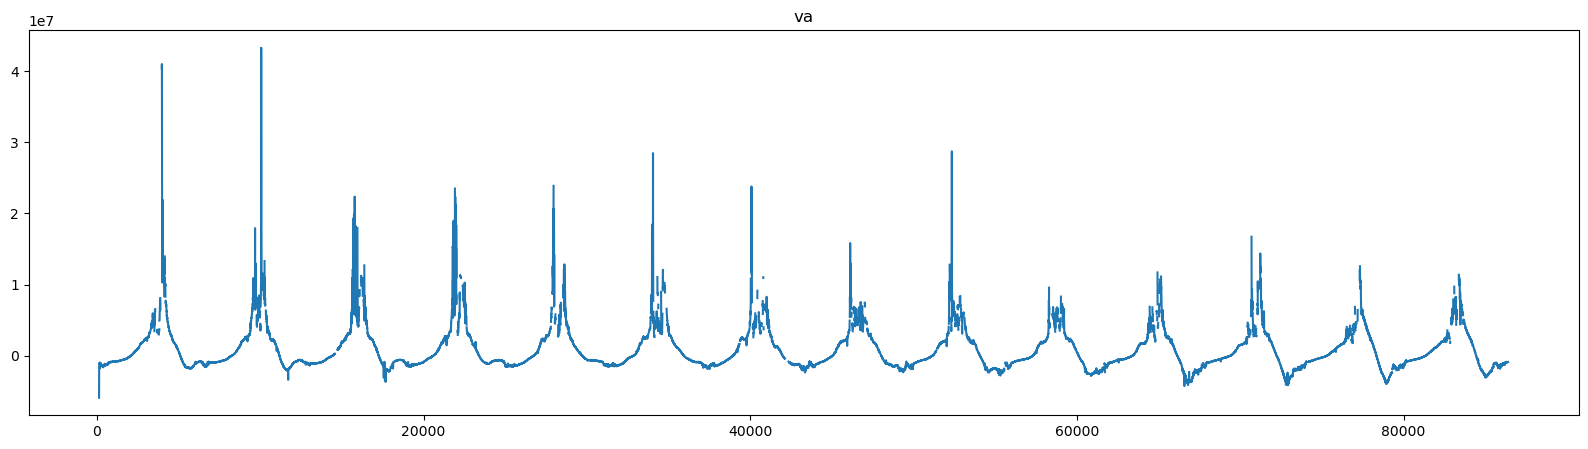

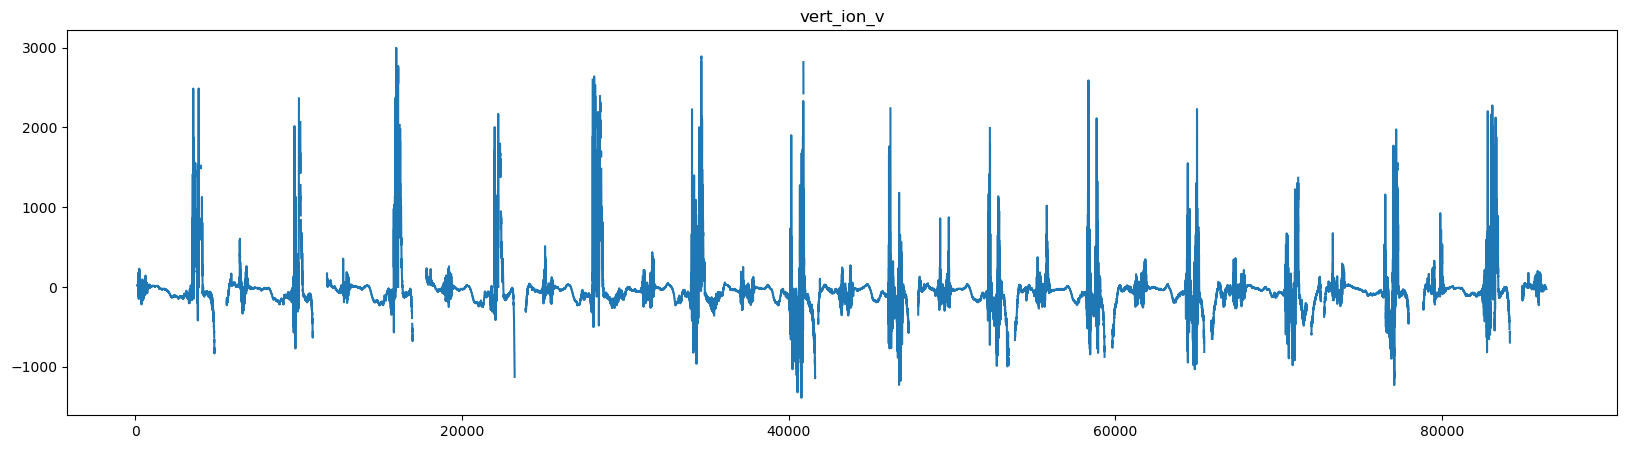

In [48]:
va,clipped_filter = get_va(data_s1=data_s1, data_ut=data_ut)
t = va.index.to_numpy()
signal = va.values
# 绘制原始信号
plt.figure(figsize=(20,5))
plt.plot(t, signal)
plt.title('va')


vert_ion_v = data_s1['vert_ion_v']
vert_ion_v = vert_ion_v[clipped_filter]
# t = vert_ion_v.index.to_numpy()  # va的index和clipped之后的任何来自s1的数据的index一样
signal = vert_ion_v.values
# 绘制原始信号
plt.figure(figsize=(20,5))
plt.plot(t, signal)
plt.title('vert_ion_v')

Text(0, 0.5, 'Amplitude')

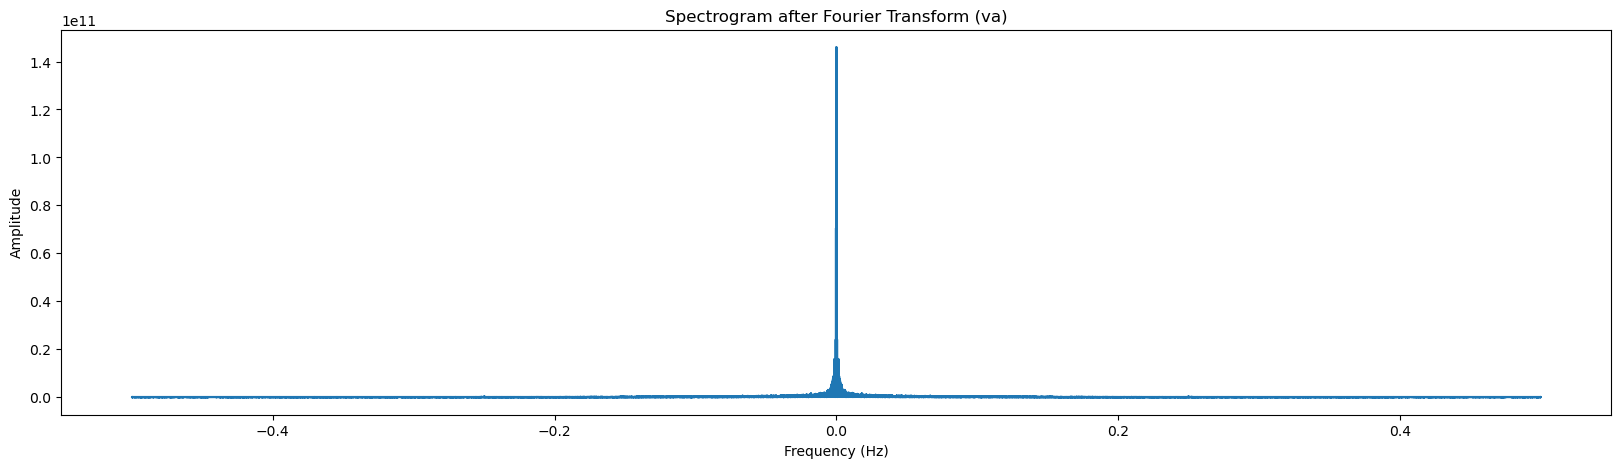

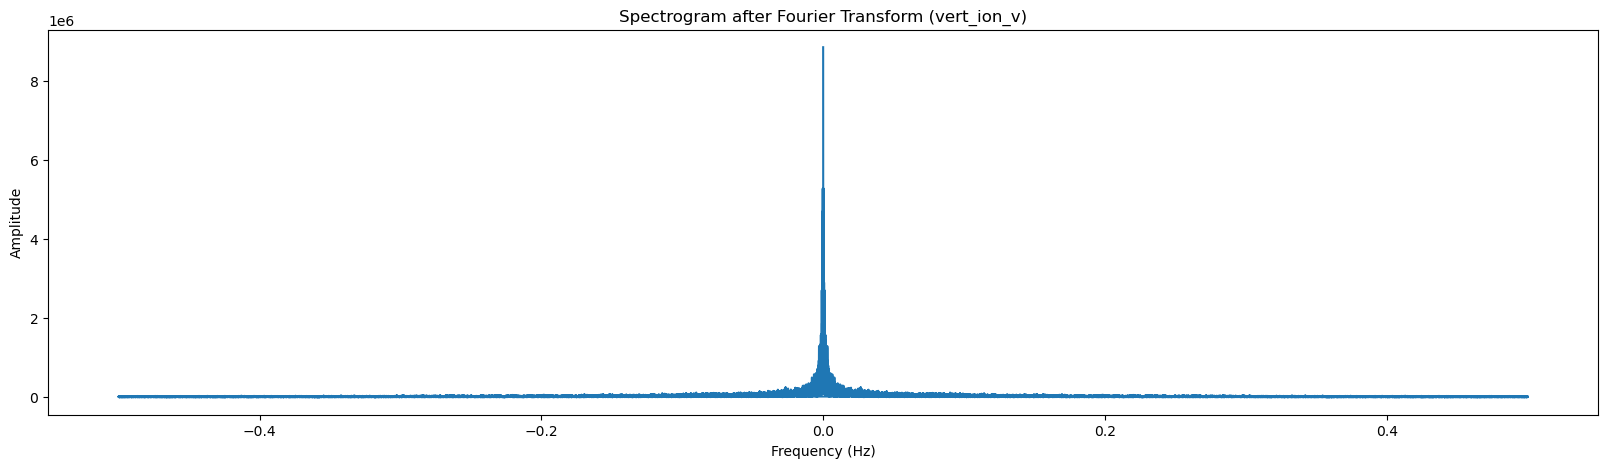

In [49]:
va = va.fillna(method='ffill').fillna(method='bfill')
t = va.index.to_numpy()
signal = va.values
# 进行傅里叶变换
signal_fft = fft(signal)
# 计算对应的频率
sample_freq = fftfreq(signal.size, d=t[1] - t[0])
# 绘制傅里叶变换结果的幅度谱（双边谱）
plt.figure(figsize=(20,5))
plt.plot(sample_freq, np.abs(signal_fft))
plt.title('Spectrogram after Fourier Transform (va)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

#
vert_ion_v = vert_ion_v.fillna(method='ffill').fillna(method='bfill')
# t = vert_ion_v.index.to_numpy()
signal = vert_ion_v.values
# 进行傅里叶变换
signal_fft = fft(signal)
# 计算对应的频率
sample_freq = fftfreq(signal.size, d=t[1] - t[0])
# 绘制傅里叶变换结果的幅度谱（双边谱）
plt.figure(figsize=(20,5))
plt.plot(sample_freq, np.abs(signal_fft))
plt.title('Spectrogram after Fourier Transform (vert_ion_v)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

Text(0, 0.5, 'vert_ion_v')

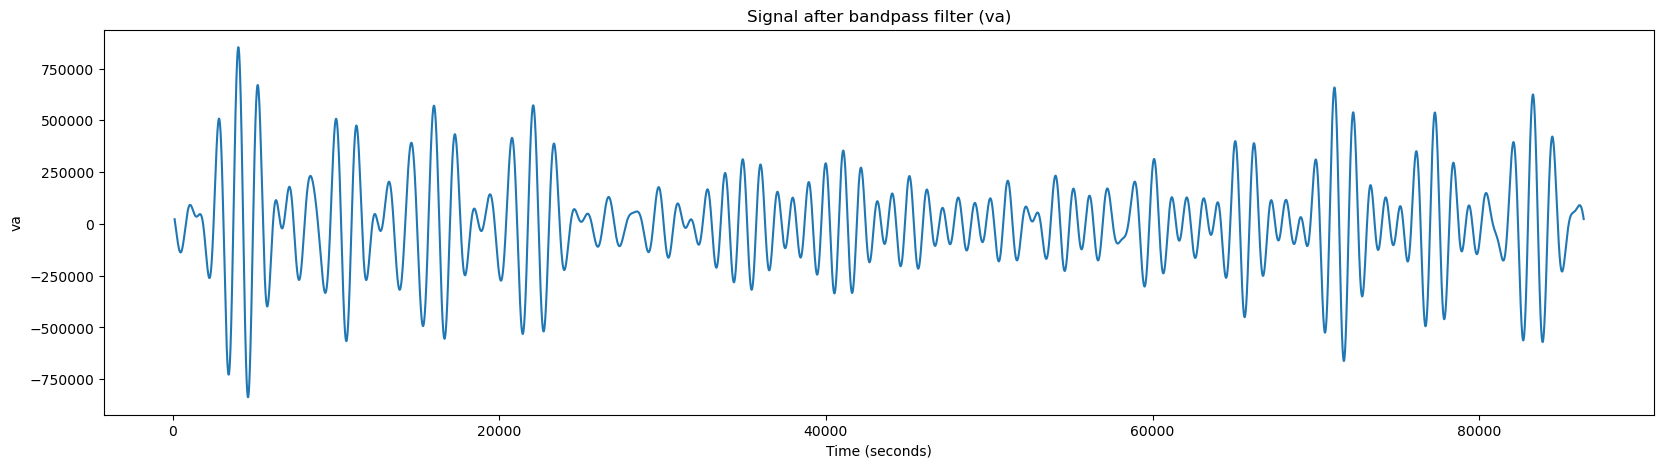

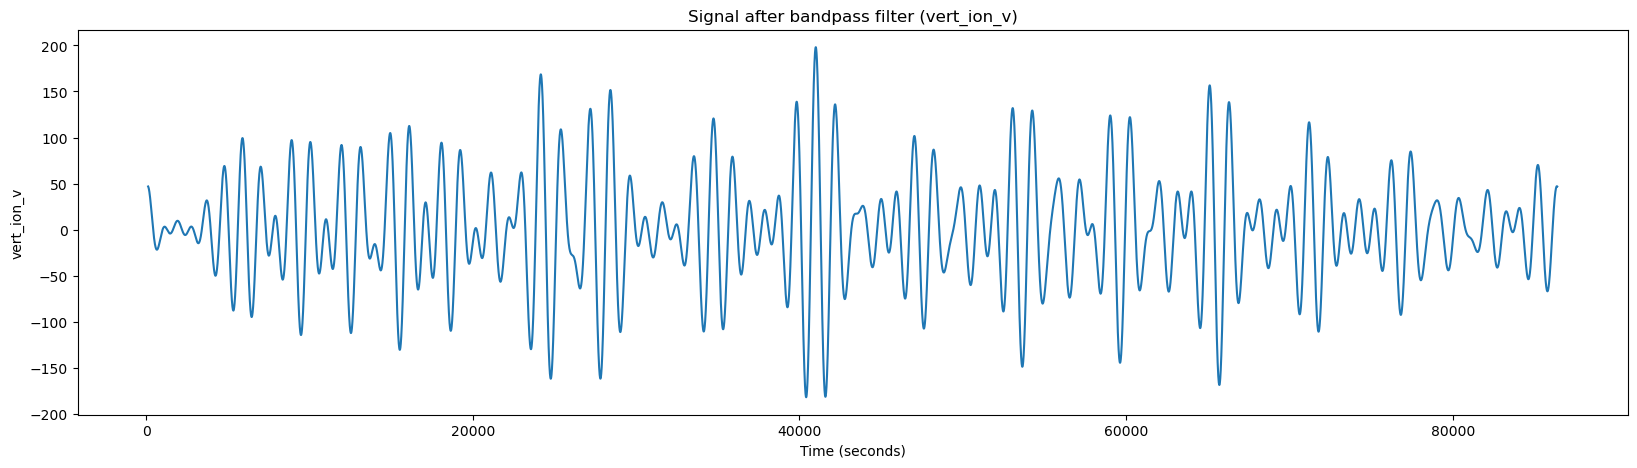

In [51]:
t = va.index.to_numpy()
signal_va = va.values
# 进行傅里叶变换
signal_fft = fft(signal_va)
# 计算对应的频率
sample_freq = fftfreq(signal_va.size, d=t[1] - t[0])
# 选取不同频率段，创建一个带通滤波器
bandpass_filter = (sample_freq > 1/1580) & (sample_freq < 1/1000)
filtered_signal_fft = signal_fft.copy()
filtered_signal_fft[~bandpass_filter] = 0
# 进行傅里叶反变换，得到过滤后的信号
filtered_signal_va = np.real(np.fft.ifft(filtered_signal_fft))

# 绘制过滤后的信号
plt.figure(figsize=(20,5))
plt.plot(t, filtered_signal_va)
plt.title(f'Signal after bandpass filter (va)')
plt.xlabel('Time (seconds)')
plt.ylabel(f'va')

#
# t = vert_ion_v.index.to_numpy()
signal_vert_ion_v = vert_ion_v.values
# 进行傅里叶变换
signal_fft = fft(signal_vert_ion_v)
# 计算对应的频率
sample_freq = fftfreq(signal_vert_ion_v.size, d=t[1] - t[0])
# 选取不同频率段，创建一个带通滤波器
bandpass_filter = (sample_freq > 1/1580) & (sample_freq < 1/1000)
filtered_signal_fft = signal_fft.copy()
filtered_signal_fft[~bandpass_filter] = 0
# 进行傅里叶反变换，得到过滤后的信号
filtered_signal_vert_ion_v = np.real(np.fft.ifft(filtered_signal_fft))

# 绘制过滤后的信号
plt.figure(figsize=(20,5))
plt.plot(t, filtered_signal_vert_ion_v)
plt.title(f'Signal after bandpass filter (vert_ion_v)')
plt.xlabel('Time (seconds)')
plt.ylabel(f'vert_ion_v')

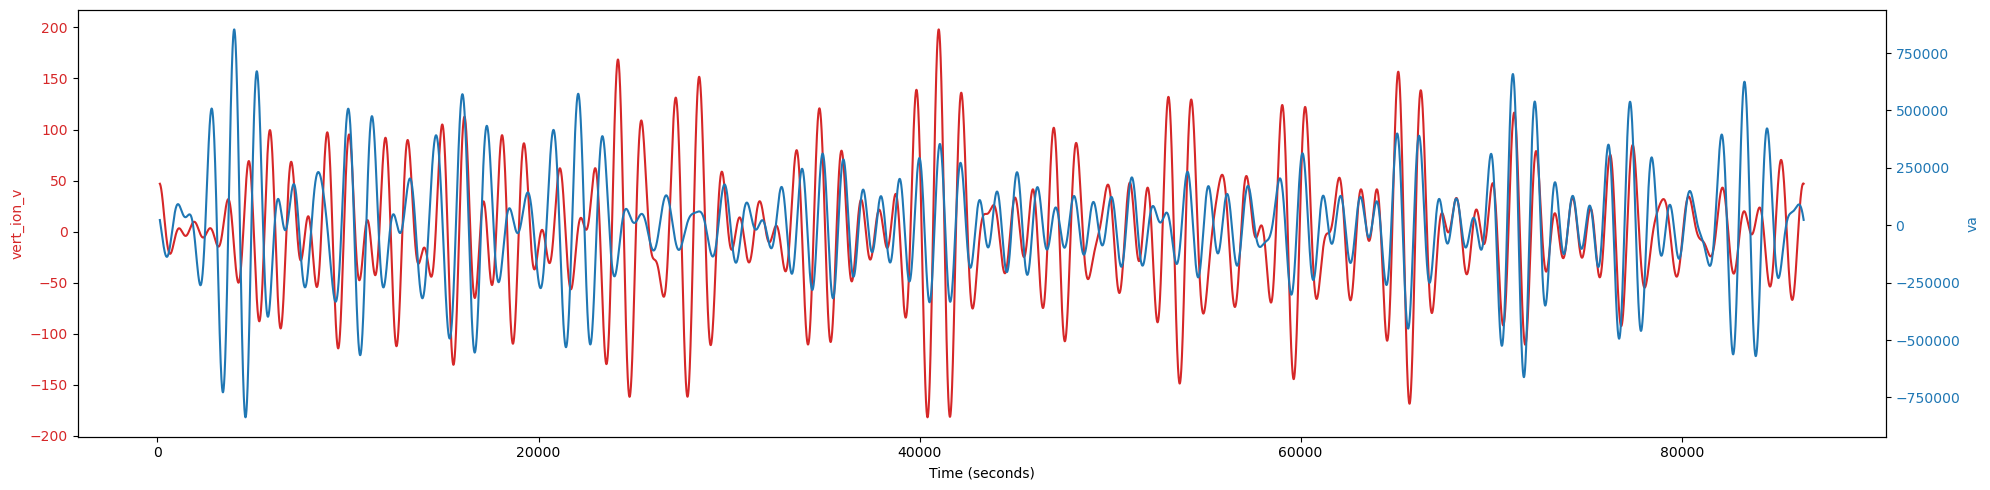

In [53]:
fig,ax1 = plt.subplots(figsize=(20,5))

# 绘制第一组数据，使用左侧y轴
color = 'tab:red'
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('vert_ion_v', color=color)
ax1.plot(t, filtered_signal_vert_ion_v, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# 创建第二个坐标轴，共享同一个x轴
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('va', color=color)
ax2.plot(t, filtered_signal_va, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# 显示图形
fig.tight_layout()  # 可选，为了更好的布局
plt.suptitle()
plt.show()